In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
torch.cuda.empty_cache()

In [3]:
# Load Kay images - code provided by Neuromatch Academy
import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

print(dat.keys())
print(dat['roi_names'])
print("Training stimluli:", dat['stimuli'].shape)
print("Training sresponses:", dat['responses'].shape)
print("Test stimluli:", dat['stimuli_test'].shape)
print("Test responses:", dat['responses_test'].shape)

Download kay_labels.npy completed!
Download kay_labels_val.npy completed!
Download kay_images.npz completed!
dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])
['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']
Training stimluli: (1750, 128, 128)
Training sresponses: (1750, 8428)
Test stimluli: (120, 128, 128)
Test responses: (120, 8428)


In [4]:
# TODO: Implement a function that splits the responses data into the ROIs
def split_by_ROI(data):
  """
  """
  V1 = data.T[dat['roi'] == 1]
  V2 = data.T[dat['roi'] == 2]
  V3 = data.T[dat['roi'] == 3]
  V3A = data.T[dat['roi'] == 4]
  V3B = data.T[dat['roi'] == 5]
  V4 = data.T[dat['roi'] == 6]
  LatOcc = data.T[dat['roi'] == 7]
  return V1.T, V2.T, V3.T, V3A.T, V3B.T, V4.T, LatOcc.T

responses_all = dat['responses'].copy()
responses_V1, responses_V2, responses_V3, responses_V3A, responses_V3B, responses_V4, responses_LO = split_by_ROI(dat['responses'])
responses_V1_test, responses_V2_test, responses_V3_test, responses_V3A_test, responses_V3B_test, responses_V4_test, responses_LO_test = split_by_ROI(dat['responses_test'])

print(responses_V1.shape)
print(responses_V2.shape)
print(responses_V3.shape)
print(responses_V3A.shape)
print(responses_V3B.shape)
print(responses_V4.shape)
print(responses_LO.shape)
print(responses_V1_test.shape)
print(responses_V2_test.shape)
print(responses_V3_test.shape)
print(responses_V3A_test.shape)
print(responses_V3B_test.shape)
print(responses_V4_test.shape)
print(responses_LO_test.shape)

(1750, 1294)
(1750, 2083)
(1750, 1790)
(1750, 484)
(1750, 314)
(1750, 1535)
(1750, 928)
(120, 1294)
(120, 2083)
(120, 1790)
(120, 484)
(120, 314)
(120, 1535)
(120, 928)


In [5]:
# Original images must be modified to be compatible with AlexNet

def preprocess(data):
  """
  Preprocesses images in Kay dataset to be compatible with the neural network.

  Args:
    - data: an ndarray containing 2D image arrays
  
  Returns: a tensor containing RGB images of size (224 x 224)
  """
  # Create empty tensor to hold preprocessed data
  preprocessed_data = torch.empty((len(data), 3, 224, 224))
  
  for idx in range(len(data)):
    image_array = data[idx]

    # Convert grayscale to RGB: duplicate grayscale value for each channel
    image_array = (image_array + np.ones_like(image_array)) / 2.0
    image_array_R = image_array.copy()
    image_array_G = image_array.copy()
    image_array_B = image_array.copy()
    image_array_RGB = np.stack((image_array_R, image_array_G, image_array_B))

    # Define preprocessing scheme
    preprocess = transforms.Compose([
      transforms.Resize(224),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Conver array to tensor and do preprocessing
    image_tensor_RGB = torch.tensor(image_array_RGB)
    new_tensor = preprocess(image_tensor_RGB)

    # Add preprocessed image to empty tensor
    preprocessed_data[idx] = new_tensor

  # Return preprocessed data
  return preprocessed_data

# preprocess the stimuli data
p_stimuli = preprocess(dat['stimuli'])
p_stimuli_test = preprocess(dat['stimuli_test'])

In [6]:
# DataLoaders will be used for training the neural network with SGD
from torch.utils.data import TensorDataset, DataLoader

# Convert all responses arrays to tensors
t_responses_all = torch.from_numpy(responses_all)
t_responses_V1 = torch.from_numpy(responses_V1)
t_responses_V2 = torch.from_numpy(responses_V2)
t_responses_V3 = torch.from_numpy(responses_V3)
t_responses_V3A = torch.from_numpy(responses_V3A)
t_responses_V3B = torch.from_numpy(responses_V3B)
t_responses_V4 = torch.from_numpy(responses_V4)
t_responses_LO = torch.from_numpy(responses_LO)

#t_responses_all_test = torch.from_numpy(responses_all_test)
t_responses_V1_test = torch.from_numpy(responses_V1_test)
t_responses_V2_test = torch.from_numpy(responses_V2_test)
t_responses_V3_test = torch.from_numpy(responses_V3_test)
t_responses_V3A_test = torch.from_numpy(responses_V3A_test)
t_responses_V3B_test = torch.from_numpy(responses_V3B_test)
t_responses_V4_test = torch.from_numpy(responses_V4_test)
t_responses_LO_test = torch.from_numpy(responses_LO_test)

# Create datasets for each ROI and one for all voxels
orig_training_all = TensorDataset(p_stimuli, t_responses_all)
orig_training_V1 = TensorDataset(p_stimuli, t_responses_V1)
orig_training_V2 = TensorDataset(p_stimuli, t_responses_V2)
orig_training_V3 = TensorDataset(p_stimuli, t_responses_V3)
orig_training_V3A = TensorDataset(p_stimuli, t_responses_V3A)
orig_training_V3B = TensorDataset(p_stimuli, t_responses_V3B)
orig_training_V4 = TensorDataset(p_stimuli, t_responses_V4)
orig_training_LO = TensorDataset(p_stimuli, t_responses_LO)

#orig_training_all_test = TensorDataset(p_stimuli, t_responses_all_test)
test_dataset_V1 = TensorDataset(p_stimuli_test, t_responses_V1_test)
test_dataset_V2 = TensorDataset(p_stimuli_test, t_responses_V2_test)
test_dataset_V3 = TensorDataset(p_stimuli_test, t_responses_V3_test)
test_dataset_V3A = TensorDataset(p_stimuli_test, t_responses_V3A_test)
test_dataset_V3B = TensorDataset(p_stimuli_test, t_responses_V3B_test)
test_dataset_V4 = TensorDataset(p_stimuli_test, t_responses_V4_test)
test_dataset_LO = TensorDataset(p_stimuli_test, t_responses_LO_test)

# Create a dataloader for the test sets
#test_loader_all = DataLoader(test_dataset_all)
test_loader_V1 = DataLoader(test_dataset_V1)
test_loader_V2 = DataLoader(test_dataset_V2)
test_loader_V3 = DataLoader(test_dataset_V3)
test_loader_V3A = DataLoader(test_dataset_V3A)
test_loader_V3B = DataLoader(test_dataset_V3B)
test_loader_V4 = DataLoader(test_dataset_V4)
test_loader_LO = DataLoader(test_dataset_LO)

# Use an 80/20 split for training and validation sets
train_dataset_all, val_dataset_all = torch.utils.data.random_split(orig_training_all, [1400, 350])
train_dataset_V1, val_dataset_V1 = torch.utils.data.random_split(orig_training_V1, [1400, 350])
train_dataset_V2, val_dataset_V2 = torch.utils.data.random_split(orig_training_V2, [1400, 350])
train_dataset_V3, val_dataset_V3 = torch.utils.data.random_split(orig_training_V3, [1400, 350])
train_dataset_V3A, val_dataset_V3A = torch.utils.data.random_split(orig_training_V3A, [1400, 350])
train_dataset_V3B, val_dataset_V3B = torch.utils.data.random_split(orig_training_V3B, [1400, 350])
train_dataset_V4, val_dataset_V4 = torch.utils.data.random_split(orig_training_V4, [1400, 350])
train_dataset_LO, val_dataset_LO = torch.utils.data.random_split(orig_training_LO, [1400, 350])

# Create dictionaries to store the test and validation sets for each ROI
dataloaders_all = {
    'train': DataLoader(train_dataset_all, batch_size=14, shuffle=True),
    'val': DataLoader(val_dataset_all, batch_size=14, shuffle=True)
}

dataloaders_V1 = {
    'train': DataLoader(train_dataset_V1, batch_size=14, shuffle=True),
    'val': DataLoader(val_dataset_V1, batch_size=14, shuffle=True)
}

dataloaders_V2 = {
    'train': DataLoader(train_dataset_V2, batch_size=14, shuffle=True),
    'val': DataLoader(val_dataset_V2, batch_size=14, shuffle=True)
}

dataloaders_V3 = {
    'train': DataLoader(train_dataset_V3, batch_size=14, shuffle=True),
    'val': DataLoader(val_dataset_V3, batch_size=14, shuffle=True)
}

dataloaders_V3A = {
    'train': DataLoader(train_dataset_V3A, batch_size=14, shuffle=True),
    'val': DataLoader(val_dataset_V3A, batch_size=14, shuffle=True)
}

dataloaders_V3B = {
    'train': DataLoader(train_dataset_V3B, batch_size=14, shuffle=True),
    'val': DataLoader(val_dataset_V3B, batch_size=14, shuffle=True)
}

dataloaders_V4 = {
    'train': DataLoader(train_dataset_V4, batch_size=14, shuffle=True),
    'val': DataLoader(val_dataset_V4, batch_size=14, shuffle=True)
}

dataloaders_LO = {
    'train': DataLoader(train_dataset_LO, batch_size=14, shuffle=True),
    'val': DataLoader(val_dataset_LO, batch_size=14, shuffle=True)
}

# Store the number of images in the training and validation sets
dataset_sizes = {
    'train': len(train_dataset_all),
    'val': len(val_dataset_all)
}

In [7]:
# Set the default device for PyTorch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Pre-load AlexNet
AlexNet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in C:\Users\aidan/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\aidan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\aidan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# The encoding model class
class EncodingModel(nn.Module):
    """
    The neural network class for the visual encoding model.
    """
    AN_NUM_OUTPUT_NEURONS = 4096
    HIDDEN_NEURONS = 2000
    V1_VOXELS = 1294
    V2_VOXELS = 2083
    V3_VOXELS = 1790
    V3A_VOXELS = 484
    V3B_VOXELS = 314
    V4_VOXELS = 1535
    LO_VOXELS = 928
    TOTAL_VOXELS = 8428

    def __init__(self, ROI=None) -> None:
        super().__init__()      # invoke nn.Module

        # Load the pre-trained AlexNet model and freeze all the layers
        AlexNet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='AlexNet_Weights.DEFAULT')
        
        # Freeze all but the classifier of AlexNet
        counter = 0
        for child in AlexNet.children():
            if counter < 2:
                for param in child.parameters():
                    param.requires_grad = False
            counter += 1
        
        #for param in AlexNet.parameters():
        #    param.requires_grad = False
            
        # Add the first two children to our model (Note: 'an' abbreviates 'AlexNet' in naming the children of this network)
        self.an_features = list(AlexNet.children())[0]
        self.an_avgpool = list(AlexNet.children())[1]

        # Access all but the last layer of the AlexNet classifier child
        features = list(AlexNet.classifier.children())[:-1]

        # Initalize output layer (by ROI if indicated)
        if ROI == 'V1':
            features.extend([nn.Linear(self.AN_NUM_OUTPUT_NEURONS, self.V1_VOXELS)])
            self.an_classifier = nn.Sequential(*features)
        elif ROI == 'V2':
            features.extend([nn.Linear(self.AN_NUM_OUTPUT_NEURONS, self.V2_VOXELS)])
            self.an_classifier = nn.Sequential(*features)
        elif ROI == 'V3':
            features.extend([nn.Linear(self.AN_NUM_OUTPUT_NEURONS, self.V3_VOXELS)])
            self.an_classifier = nn.Sequential(*features)
        elif ROI == 'V3A':
            features.extend([nn.Linear(self.AN_NUM_OUTPUT_NEURONS, self.V3A_VOXELS)])
            self.an_classifier = nn.Sequential(*features)
        elif ROI == 'V3B':
            features.extend([nn.Linear(self.AN_NUM_OUTPUT_NEURONS, self.V3B_VOXELS)])
            self.an_classifier = nn.Sequential(*features)
        elif ROI == 'V4':
            features.extend([nn.Linear(self.AN_NUM_OUTPUT_NEURONS, self.V4_VOXELS)])
            self.an_classifier = nn.Sequential(*features)
        elif ROI == 'LO':
            features.extend([nn.Linear(self.AN_NUM_OUTPUT_NEURONS, self.LO_VOXELS)])
            self.an_classifier = nn.Sequential(*features)
        else:
            features.extend([nn.Linear(self.AN_NUM_OUTPUT_NEURONS, self.V1_VOXELS)])
            self.an_classifier = nn.Sequential(*features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implements foward pass from AlexNet"""
        x = self.an_features(x)
        x = self.an_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.an_classifier(x)

        return x

In [9]:
def train(model, dataloaders, num_epochs=25, learn_rate=.001, l2=.003):
    """
    Trains the model using CosineEmbeddingLoss and tracks training statistics.

    Args:
    - model (EncodingModel): an EncodingModel object to be trained
    - dataloaders (dictionary): a dictionary containing DataLoaders for training and validation
    - num_epochs (int, optional): number of epochs of SGD to run
    - learn_rate (float, optional): the learning rate for SGD

    Returns: an EncodingModel loaded with parameters that resulted in the lowest loss on the validation set
    """
    since = time.time()
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learn_rate, weight_decay=l2)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CosineEmbeddingLoss()
    best_model_wts = copy.deepcopy(model.state_dict())
    lowest_loss = np.inf

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Train and validate for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluate mode
            
            running_loss = 0.

            # Iterate through data
            for stimuli, responses in dataloaders[phase]:
                stimuli = stimuli.to(DEVICE)
                responses = responses.to(DEVICE)

                # Zero gradients
                optimizer.zero_grad()

                # forward, track history only in training mode
                with torch.set_grad_enabled(phase == 'train'):
                    # Compute model prediction
                    predictions = model(stimuli)

                    # Compute loss
                    loss = loss_fn(predictions, responses, torch.ones_like(predictions[:,0]))
                    
                # backward, optimize only in training mode
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Compute running loss
                running_loss += loss.item()
            if phase == 'train':
                scheduler.step()
            
            # Report average loss for current epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f}')

            # Deep copy the model if higher validation score
            if phase == 'val' and epoch_loss < lowest_loss:
                lowest_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {lowest_loss:4f}')
    
    # Return the best model
    model.load_state_dict(best_model_wts)
    return model

This notebook tests the model using the V1 voxels for training and prediction.

In [10]:
EncodingModel2_V1 = EncodingModel(ROI='V1')
print(EncodingModel2_V1)
for param in EncodingModel2_V1.parameters():
    print(param.requires_grad)

Using cache found in C:\Users\aidan/.cache\torch\hub\pytorch_vision_v0.10.0


EncodingModel(
  (an_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (an_avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (an_classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=409

In [11]:
EncodingModel2_V1.to(DEVICE)
EncodingModel2_V1 = train(EncodingModel2_V1, dataloaders_V1)

Epoch 1/25
----------
train Loss: 0.0712
val Loss: 0.0712

Epoch 2/25
----------
train Loss: 0.0706
val Loss: 0.0710

Epoch 3/25
----------
train Loss: 0.0699
val Loss: 0.0707

Epoch 4/25
----------
train Loss: 0.0693
val Loss: 0.0704

Epoch 5/25
----------
train Loss: 0.0685
val Loss: 0.0701

Epoch 6/25
----------
train Loss: 0.0678
val Loss: 0.0697

Epoch 7/25
----------
train Loss: 0.0671
val Loss: 0.0693

Epoch 8/25
----------
train Loss: 0.0665
val Loss: 0.0693

Epoch 9/25
----------
train Loss: 0.0664
val Loss: 0.0692

Epoch 10/25
----------
train Loss: 0.0663
val Loss: 0.0692

Epoch 11/25
----------
train Loss: 0.0662
val Loss: 0.0691

Epoch 12/25
----------
train Loss: 0.0661
val Loss: 0.0691

Epoch 13/25
----------
train Loss: 0.0661
val Loss: 0.0691

Epoch 14/25
----------
train Loss: 0.0661
val Loss: 0.0690

Epoch 15/25
----------
train Loss: 0.0660
val Loss: 0.0690

Epoch 16/25
----------
train Loss: 0.0659
val Loss: 0.0690

Epoch 17/25
----------
train Loss: 0.0660
val Los

In [12]:
# A function to format all predictions on test set into a single 2D array

def visualize_predictions(model, test_loader, ROI=None):
  """
  not so sure about the shape of output yet, might bug out
  """
  torch.Tensor.ndim = property(lambda self: len(self.shape))

  model.eval()

  if ROI == 'V1':
    predictions = torch.empty((120, 1294))
  elif ROI == 'V2':
    predictions = torch.empty((120, 2083))
  elif ROI == 'V3':
    predictions = torch.empty((120, 1790))
  elif ROI == 'V3A':
    predictions = torch.empty((120, 484))
  elif ROI == 'V3B':
    predictions = torch.empty((120, 314))
  elif ROI == 'V4':
    predictions = torch.empty((120, 1535))
  elif ROI == 'LO':
    predictions = torch.empty((120, 928))
  else:
    predictions = torch.empty((120, 8428))
  
  with torch.no_grad():
    for i, data in enumerate(test_loader):
      stimuli_test, _ = data
      stimuli_test = stimuli_test.to(DEVICE)

      prediction = model(stimuli_test)

      predictions[i] = prediction

  params = {'axes.titlesize': 20}  
  plt.rcParams.update(params)
  fig, ax = plt.subplots(figsize=(12, 5))
  plt.title(ROI + " (Prediction)")
  ax.set(xlabel="Predicted Voxel Response", ylabel="Test Stimulus")
  heatmap = ax.imshow(predictions,
                      aspect="auto", vmin=-1, vmax=1, cmap="bwr")
  fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
  fig.tight_layout()
  fig.show()

C:\Users\aidan\AppData\Local\Temp\ipykernel_14892\1392445243.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


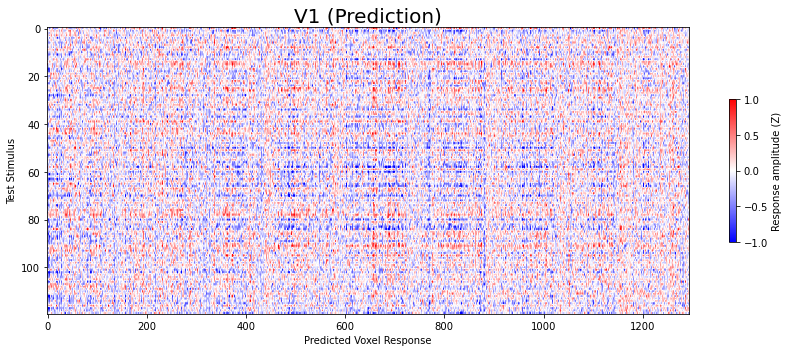

In [13]:
# Predict for V1
visualize_predictions(EncodingModel2_V1, test_loader_V1, ROI='V1')

C:\Users\aidan\AppData\Local\Temp\ipykernel_14892\3956003305.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


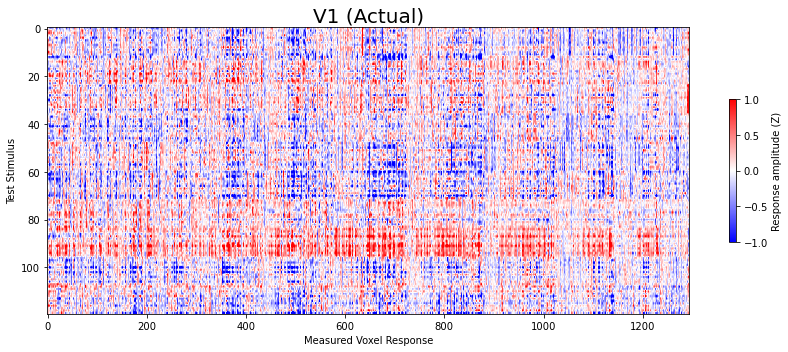

In [14]:
# Compare to real V1 data
params = {'axes.titlesize': 20}  
plt.rcParams.update(params)
fig, ax = plt.subplots(figsize=(12, 5))
plt.title('V1 (Actual)')
ax.set(xlabel="Measured Voxel Response", ylabel="Test Stimulus")
heatmap = ax.imshow(responses_V1_test,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()